In [12]:
# install machine gnostics
# recommended to run in a new virtual environment

# !pip install machinegnostics #<-- Uncomment this line to install the package

# Gnostic Random Forest Classifier

### **Overview**
The **Machine Gnostics Random Forest Classifier** extends the powerful random forest ensemble method with **Gnostic Weighted Learning**. It combines the variance-reduction properties of bagging with the robustness of gnostic reweighting.

Key advantages:
- **Robustness**: Identifies and down-weights mislabeled training data (label noise).
- **Reduced Overfitting**: Fits better to the "true" conceptual distribution rather than noisy samples.
- **Ensemble Power**: Leverages multiple trees for higher accuracy and stability.
- **Adaptive**: Iteratively refines the importance of training samples.

---

### **Theoretical Background**

Standard Random Forests use bootstrap aggregating (bagging) to learn from various subsets of data. The **Gnostic Random Forest** adds an outer loop of optimization:

1.  **Ensemble Fit**: A random forest is trained on the current weighted dataset.
2.  **Consensus Check**: The ensemble's predictions are compared to the actual labels.
3.  **Gnostic Weighting**: Samples where the ensemble strongly disagrees with the label (high Gnostic Dissonance) receive lower weights.
4.  **Refinement**: The next iteration's forest focuses more on the reliable (high-weight) samples.

This effectively filters out label noise and extreme outliers that would otherwise corrupt the decision boundaries.

***

## Example 1: Classification with Label Noise

Standard Random Forests can be sensitive to label noise in complex boundaries. We'll show how the Gnostic variant handles a dataset where some labels are incorrect.

Dataset: 100 samples (Moons shape with noise)
Train set: 70 samples
Test set: 30 samples


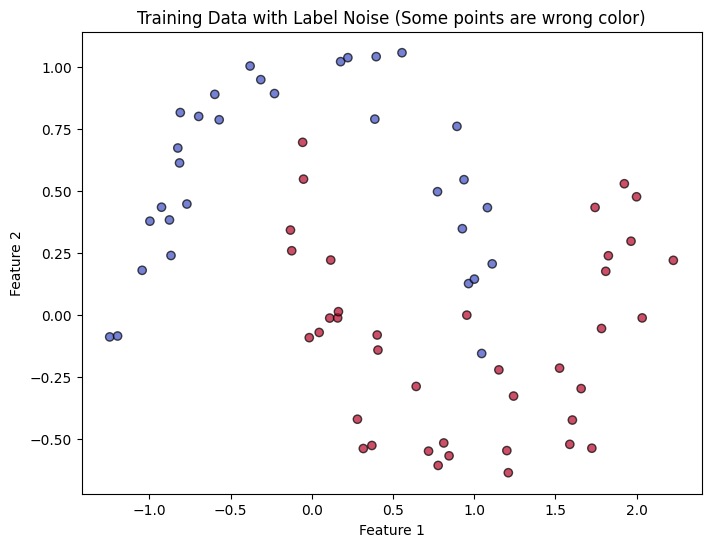

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from machinegnostics.models import GnosticRandomForestClassifier, train_test_split
from machinegnostics.metrics import accuracy_score, classification_report
from machinegnostics.data import make_moons_check_data


# Generate synthetic data
X, y = make_moons_check_data(n_samples=100, noise=0.15,)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_seed=42)

print(f"Dataset: {X.shape[0]} samples (Moons shape with noise)")
print(f"Train set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Visualize
plt.figure(figsize=(8, 6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='coolwarm', edgecolors='k', alpha=0.7)
plt.title("Training Data with Label Noise (Some points are wrong color)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

In [14]:
# Initialize and train Gnostic Random Forest
model = GnosticRandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    gnostic_weights=True,
    max_iter=10,
    tolerance=1e-4,
    verbose=True
)

print("Training Gnostic Random Forest Classifier...")
model.fit(X_train, y_train)

print(f"\nModel trained!")
print(f"Iterations run: {model._iter}")
try:
    print(f"Final loss: {model.cross_entropy_loss:.6f}")
except:
    pass

2026-02-03 17:28:21,806 | GnosticRandomForestClassifier | INFO | GnosticRandomForestClassifier initialized.
2026-02-03 17:28:21,812 | GnosticRandomForestClassifier | INFO | HistoryCartClassifierBase initialized.
2026-02-03 17:28:21,813 | GnosticRandomForestClassifier | INFO | Starting fit process for GnosticRandomForestClassifier.
2026-02-03 17:28:21,814 | GnosticRandomForestClassifier | INFO | Starting fit input/output processing.
2026-02-03 17:28:21,817 | GnosticRandomForestClassifier | INFO | Checking input X of type: <class 'numpy.ndarray'>
2026-02-03 17:28:21,819 | GnosticRandomForestClassifier | INFO | Identifying and converting data of type: <class 'numpy.ndarray'>
2026-02-03 17:28:21,820 | GnosticRandomForestClassifier | INFO | Checking target y of type: <class 'numpy.ndarray'>
2026-02-03 17:28:21,822 | GnosticRandomForestClassifier | INFO | Identifying and converting data of type: <class 'numpy.ndarray'>
2026-02-03 17:28:21,823 | GnosticRandomForestClassifier | INFO | Starting

Training Gnostic Random Forest Classifier...


2026-02-03 17:28:21,955 | GnosticRandomForestClassifier | INFO | Iteration 3: Loss 66.31421533489326, Rentropy 0.8232605201153461
2026-02-03 17:28:21,991 | GnosticRandomForestClassifier | INFO | Iteration 4: Loss 67.57785557744096, Rentropy 0.8247391378193768
2026-02-03 17:28:22,027 | GnosticRandomForestClassifier | INFO | Iteration 5: Loss 65.35760054842386, Rentropy 0.8408163121695365
2026-02-03 17:28:22,061 | GnosticRandomForestClassifier | INFO | Iteration 6: Loss 67.47037539102708, Rentropy 0.9189601464312078
2026-02-03 17:28:22,094 | GnosticRandomForestClassifier | INFO | Iteration 7: Loss 69.0246029580536, Rentropy 0.9664008076070851
2026-02-03 17:28:22,128 | GnosticRandomForestClassifier | INFO | Iteration 8: Loss 68.99833033207499, Rentropy 0.8976388428349257
2026-02-03 17:28:22,161 | GnosticRandomForestClassifier | INFO | Iteration 9: Loss 68.99996679517906, Rentropy 0.9029372311656618
2026-02-03 17:28:22,195 | GnosticRandomForestClassifier | INFO | Iteration 10: Loss 68.9745


Model trained!
Iterations run: 10


In [15]:
# Predict and Evaluate
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test, y_pred_test)

print("Model Performance:")
print("=" * 50)
print(f"Training Accuracy: {acc_train:.4f}")
print(f"Test Accuracy:     {acc_test:.4f}")
print("=" * 50)

print("\nClassification Report (Test):")
print(classification_report(y_test, y_pred_test))

2026-02-03 17:28:22,227 | GnosticRandomForestClassifier | INFO | Making predictions with GnosticRandomForestClassifier.
2026-02-03 17:28:22,227 | GnosticRandomForestClassifier | INFO | Starting predict input/output processing.
2026-02-03 17:28:22,227 | GnosticRandomForestClassifier | INFO | Checking input X for prediction of type: <class 'numpy.ndarray'>
2026-02-03 17:28:22,228 | GnosticRandomForestClassifier | INFO | Checking input X of type: <class 'numpy.ndarray'>
2026-02-03 17:28:22,229 | GnosticRandomForestClassifier | INFO | Identifying and converting data of type: <class 'numpy.ndarray'>
2026-02-03 17:28:22,236 | GnosticRandomForestClassifier | INFO | Making predictions with GnosticRandomForestClassifier.
2026-02-03 17:28:22,236 | GnosticRandomForestClassifier | INFO | Starting predict input/output processing.
2026-02-03 17:28:22,236 | GnosticRandomForestClassifier | INFO | Checking input X for prediction of type: <class 'numpy.ndarray'>
2026-02-03 17:28:22,236 | GnosticRandomFo

Model Performance:
Training Accuracy: 0.8000
Test Accuracy:     0.8667

Classification Report (Test):
Class           Precision    Recall  F1-score   Support
0                    0.94      0.84      0.89        19
1                    0.77      0.91      0.83        11
Avg/Total            0.88      0.87      0.87        30



### Visualization: Decision Boundaries

Visualizing how well the model separates the two moons despite the noise.

2026-02-03 17:28:22,250 | GnosticRandomForestClassifier | INFO | Making predictions with GnosticRandomForestClassifier.
2026-02-03 17:28:22,250 | GnosticRandomForestClassifier | INFO | Starting predict input/output processing.
2026-02-03 17:28:22,251 | GnosticRandomForestClassifier | INFO | Checking input X for prediction of type: <class 'numpy.ndarray'>
2026-02-03 17:28:22,251 | GnosticRandomForestClassifier | INFO | Checking input X of type: <class 'numpy.ndarray'>
2026-02-03 17:28:22,251 | GnosticRandomForestClassifier | INFO | Identifying and converting data of type: <class 'numpy.ndarray'>


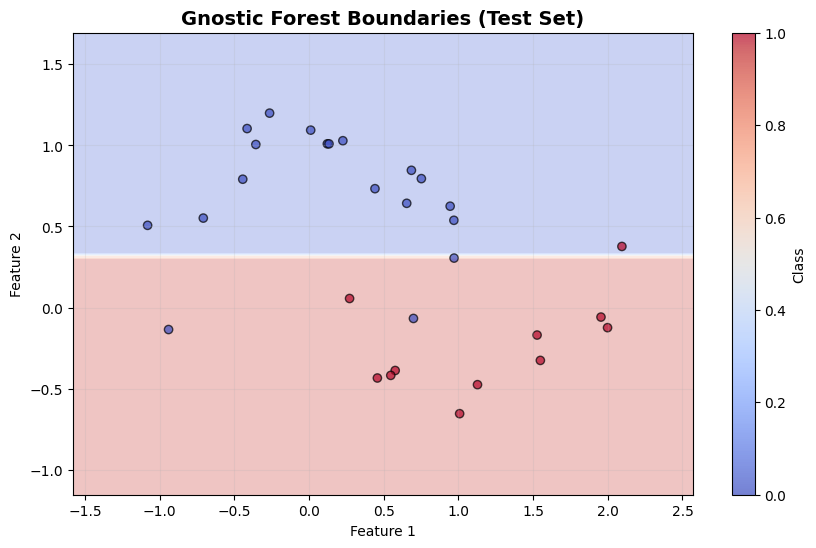

In [16]:
def plot_decision_boundary(model, X, y, title="Decision Boundary"):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    h = 0.05
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    
    # Plot data points
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolors='k', alpha=0.7)
    
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.colorbar(scatter, label='Class')
    plt.grid(True, alpha=0.2)
    plt.show()

plot_decision_boundary(model, X_test, y_test, "Gnostic Forest Boundaries (Test Set)")

## Example 2: Understanding Gnostic Weights

The model identifies and down-weights samples where the ensemble consensus clashes with the given label. These are likely the noisy labels we introduced.

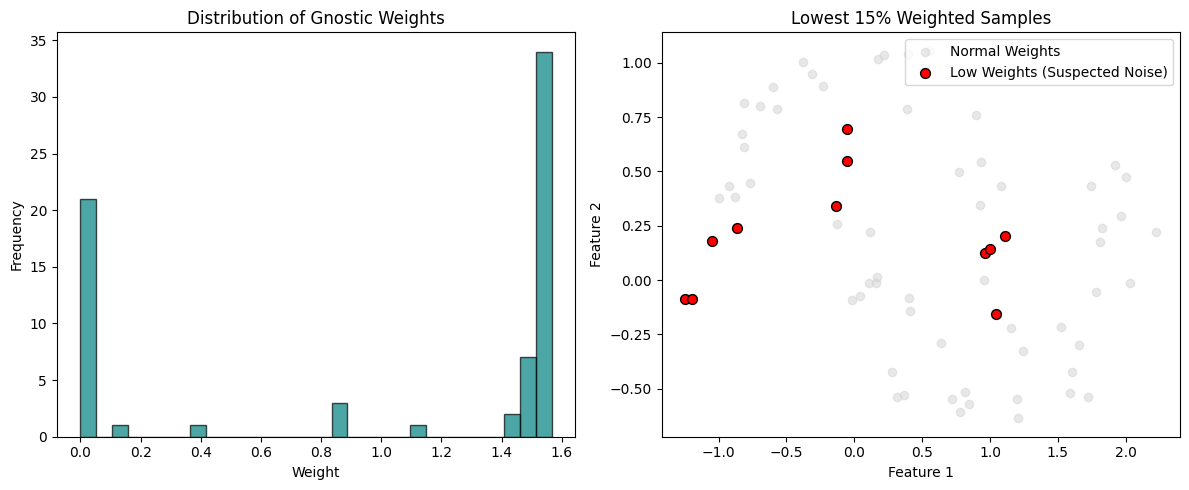

Average weight: 1.0000
Min weight: 0.0000


In [17]:
# Inspect Weights
weights = model.weights

# Visualize weights distribution
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(weights, bins=30, color='teal', edgecolor='black', alpha=0.7)
plt.title('Distribution of Gnostic Weights')
plt.xlabel('Weight')
plt.ylabel('Frequency')

# Visualize low-weight samples on the dataset
# We'll highlight the samples with the lowest weights
threshold_val = np.percentile(weights, 15)
low_weight_mask = weights < threshold_val

plt.subplot(1, 2, 2)
# Plot all points
plt.scatter(X_train[:, 0], X_train[:, 1], c='lightgray', alpha=0.5, label='Normal Weights')
# Highlight low weights
plt.scatter(X_train[low_weight_mask, 0], X_train[low_weight_mask, 1], c='red', s=50, edgecolors='k', label='Low Weights (Suspected Noise)')
plt.title(f'Lowest 15% Weighted Samples')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Average weight: {np.mean(weights):.4f}")
print(f"Min weight: {np.min(weights):.4f}")

## Model History

Tracking the convergence of the gnostic optimization loop.

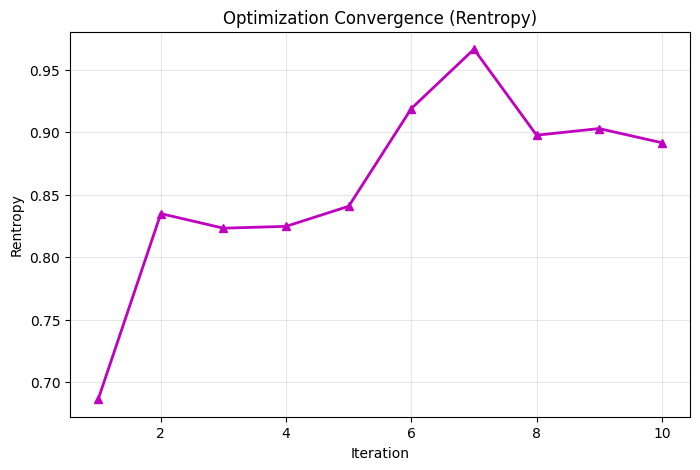

Initial Rentropy: None
Final Rentropy: 0.8916136999821275


In [18]:
history = model._history

if len(history) > 1:
    iterations = [h['iteration'] for h in history if h['iteration'] is not None]
    
    # Plot loss or rentropy
    if 'rentropy' in history[1]:
        metric = 'rentropy'
        title = 'Rentropy'
    else:
        metric = 'cross_entropy_loss'
        title = 'Loss'
        
    values = [h.get(metric, np.nan) for h in history if h['iteration'] is not None]
    
    plt.figure(figsize=(8, 5))
    plt.plot(iterations, values, 'm-^', linewidth=2)
    plt.title(f'Optimization Convergence ({title})')
    plt.xlabel('Iteration')
    plt.ylabel(title)
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print(f"Initial {title}: {values[0]}")
    print(f"Final {title}: {values[-1]}")
else:
    print("Model converged in 1 iteration or history not available.")